# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-m`
  - Task 5: Evaluating our Retriever



## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

>> NOTE: You do not need to do these steps if you are running this notebook locally with `uv`.

In [5]:
#!pip install -qU langchain_openai langchain_huggingface langchain_core langchain langchain_community langchain-text-splitters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/20

In [6]:
 #!pip install -qU faiss-cpu python-pptx==1.0.2 nltk==3.9.1 pymupdf beautifulsoup4 lxml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 11.9 MB/s eta 0:00:00


### Provide OpenAI API Key

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

## Task 2: Loading Data


In [6]:
#!pip install -qU pypdf
# uv add pypdf

In [4]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader

path = "pdf/"
text_loader = DirectoryLoader(path, loader_cls=PyPDFLoader)
docs = text_loader.load()

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, #750
    chunk_overlap  = 50, #20
    length_function = len
)

Next we can load/split these documents as follows.

>> NOTE: You may need to run this cell twice to get it to work.

In [6]:
training_documents = text_splitter.split_documents(text_loader.load())

In [7]:
len(training_documents)

423

Next, we're going to associate each of our chunks with a unique identifier.

In [8]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [9]:
training_split_documents = training_documents[:len(training_documents) - 100]
val_split_documents = training_documents[len(training_documents) - 100:423-50]
test_split_documents = training_documents[423-50:]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [today](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [10]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [11]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [12]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

In [13]:
import tqdm
def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}
  for document in tqdm.tqdm(documents):
    document_content = {"context" : document.page_content, "questions" : []}
    questions_generated = question_generation_chain.invoke({"context": document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]
  return questions, relevant_docs

In [14]:
training_questions, training_relevant_contexts = create_questions(training_split_documents, 2)

100%|██████████| 323/323 [05:09<00:00,  1.04it/s]


We'll use the function to generate training, validation, and test data.

In [15]:
val_questions, val_relevant_contexts = create_questions(val_split_documents, 2)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [16]:
test_questions, test_relevant_contexts = create_questions(test_split_documents, 2)

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

In [17]:
import json

training_corpus = {train_item.metadata["id"] : train_item.page_content for train_item in training_split_documents}

train_dataset = {
    "questions" : training_questions,
    "relevant_contexts" : training_relevant_contexts,
    "corpus" : training_corpus
}

with open("training_dataset.jsonl", "w") as f:
  json.dump(train_dataset, f)

In [18]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [19]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-m`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-m`](https://huggingface.co/Snowflake/snowflake-arctic-embed-m) as a base embeddings model.


In [32]:
#!pip install -qU sentence_transformers datasets pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.1 which is incompatible.
pylibcudf-cu12 24.12.0 requires pyarrow<19.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 19.0.1 which is incompatible.


In [20]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-m"
model = SentenceTransformer(model_id)

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [22]:
BATCH_SIZE = 10

Let's move our dataset into the expected format for training.

In [23]:
corpus = train_dataset['corpus']
queries = train_dataset['questions']
relevant_docs = train_dataset['relevant_contexts']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [24]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [25]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [26]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

In [27]:
print(len(val_dataset['questions']))  # Check the number of validation questions

100


We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [28]:
EPOCHS = 10

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [29]:
import wandb
wandb.init(mode="disabled")

In [30]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic_ft',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss,Cosine Accuracy@1,Cosine Accuracy@3,Cosine Accuracy@5,Cosine Accuracy@10,Cosine Precision@1,Cosine Precision@3,Cosine Precision@5,Cosine Precision@10,Cosine Recall@1,Cosine Recall@3,Cosine Recall@5,Cosine Recall@10,Cosine Ndcg@10,Cosine Mrr@10,Cosine Map@100
50,No log,No log,0.780000,0.940000,0.970000,1.000000,0.780000,0.313333,0.194000,0.100000,0.780000,0.940000,0.970000,1.000000,0.895919,0.861706,0.861706
65,No log,No log,0.780000,0.930000,0.960000,0.990000,0.780000,0.310000,0.192000,0.099000,0.780000,0.930000,0.960000,0.990000,0.893194,0.861286,0.862195
100,No log,No log,0.730000,0.940000,0.980000,1.000000,0.730000,0.313333,0.196000,0.100000,0.730000,0.940000,0.980000,1.000000,0.878552,0.837833,0.837833
130,No log,No log,0.780000,0.960000,0.990000,0.990000,0.780000,0.320000,0.198000,0.099000,0.780000,0.960000,0.990000,0.990000,0.899065,0.868167,0.869076
150,No log,No log,0.810000,0.960000,0.990000,0.990000,0.810000,0.320000,0.198000,0.099000,0.810000,0.960000,0.990000,0.990000,0.910137,0.883167,0.884000
195,No log,No log,0.770000,0.960000,0.970000,1.000000,0.770000,0.320000,0.194000,0.100000,0.770000,0.960000,0.970000,1.000000,0.894626,0.859750,0.859750
200,No log,No log,0.780000,0.960000,0.980000,1.000000,0.780000,0.320000,0.196000,0.100000,0.780000,0.960000,0.980000,1.000000,0.898185,0.864583,0.864583
250,No log,No log,0.790000,0.960000,0.980000,1.000000,0.790000,0.320000,0.196000,0.100000,0.790000,0.960000,0.980000,1.000000,0.905375,0.873845,0.873845
260,No log,No log,0.800000,0.960000,0.980000,1.000000,0.800000,0.320000,0.196000,0.100000,0.800000,0.960000,0.980000,1.000000,0.908627,0.878345,0.878345
300,No log,No log,0.780000,0.960000,0.980000,1.000000,0.780000,0.320000,0.196000,0.100000,0.780000,0.960000,0.980000,1.000000,0.901863,0.869024,0.869024


In [31]:
from huggingface_hub import notebook_login

notebook_login()

In [32]:
hf_username = "philipk22"

In [59]:
model.push_to_hub(f"{hf_username}/ind312-ft-v0")

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

'https://huggingface.co/philipk22/ind312-ft-v0/commit/9aa76ca50a2e32d8d5be1f1c112962151bebbc67'

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [33]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [34]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-l`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [64]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 100/100 [00:38<00:00,  2.58it/s]


In [65]:
te3_results_df = pd.DataFrame(te3_results)

In [66]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

0.95

### `Snowflake/snowflake-arctic-embed-m` (base)

In [35]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 100/100 [00:00<00:00, 165.75it/s]


In [36]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [37]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

np.float64(0.68)

### `Snowflake/snowflake-arctic-embed-m` (fine-tuned)

In [38]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="philipk22/ind312-ft-v0")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at philipk22/ind312-ft-v0 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [00:00<00:00, 162.52it/s]


In [39]:
finetune_results_df = pd.DataFrame(finetune_results)

In [40]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

np.float64(0.99)

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [41]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500, # 600
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(text_loader.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [48]:
#from langchain_community.vectorstores import FAISS

#base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
#base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

In [83]:
from langchain_community.embeddings import HuggingFaceBgeEmbeddings

embedding_model = HuggingFaceBgeEmbeddings(
        model_name="BAAI/bge-base-en-v1.5",
        encode_kwargs={'normalize_embeddings': True}
    )

/tmp/ipykernel_1425419/4089610438.py:3: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceBgeEmbeddings(


In [98]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ind-1536",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)

base_vector_store = QdrantVectorStore(
    client=client,
    collection_name="ind-1536",
 #   embedding=huggingface_embeddings
    embedding=embedding_model
)


In [99]:
_ = base_vector_store.add_documents(documents=training_documents)

In [100]:
base_retriever = base_vector_store.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [49]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [50]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [101]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [102]:
base_rag_chain.invoke({"question" : "What type of studies are required before submitting an IND?"})["response"]

'The context does not provide specific details about the types of studies required before submitting an IND (Investigational New Drug Application). Therefore, I do not know the answer.'

In [103]:
base_rag_chain.invoke({"question" : "What happen if the FDA places a clinical hold on an IND application?"})["response"]

'If the FDA places a clinical hold on an IND application, it issues an order to the sponsor to delay a proposed clinical investigation or to suspend an ongoing investigation. This means that subjects may not be given the investigational drug in a proposed study, and no new subjects may be enrolled in an ongoing study. The sponsor cannot proceed with the clinical trial until the hold has been lifted by the FDA.'

In [104]:
base_rag_chain.invoke({"question" : "what about Compile Drug Substance Information?"})["response"]

'The submission for drug substance information should include a description of the drug substance, detailing its physical, chemical, or biological characteristics, the name and address of its manufacturer, the general method of preparation, acceptable limits, and analytical methods used to assure its identity, strength, quality, and purity. Additionally, it should encompass information on pharmacology, drug disposition, toxicology, and any risks anticipated based on toxicological data. The emphasis in an initial Phase 1 submission should be on the identification and control of raw materials and the new drug substance, with final specifications expected at the end of the investigational process.'

In [105]:
base_rag_chain.invoke({"question" : "What is the meaning of 'inactive IND' in section 312.45?"})["response"]

"An 'inactive IND' refers to an investigational new drug application that has been placed on inactive status by the FDA. This can occur if the IND has remained inactive for 5 years or more, or if the FDA determines that the sponsor has failed to comply with certain requirements. While an inactive IND is still in effect for purposes of public disclosure of data and information, the sponsor is not required to submit annual reports during this inactive status. If the sponsor intends to resume clinical investigations under an inactive IND, they must submit a protocol amendment containing the proposed general investigational plan."

In [106]:
base_rag_chain.invoke({"question" : "Under section 312.56, what are the situations in which the FDA may suspend an IND?"})["response"]

'I do not know.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [57]:
#finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
#finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [117]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(":memory:")

client.create_collection(
    collection_name="ind-1536",
    vectors_config=VectorParams(size=768, distance=Distance.COSINE)
)

finetuned_vector_store = QdrantVectorStore(
    client=client,
    collection_name="ind-1536",
#    embedding=huggingface_embeddings
    embedding=finetune_embeddings
)

In [118]:
_ = finetuned_vector_store.add_documents(documents=training_documents)

In [119]:
finetune_retriever = finetuned_vector_store.as_retriever(search_kwargs={"k": 6})

In [120]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [121]:
finetune_rag_chain.invoke({"question" : "What type of studies are required before submitting an IND?"})["response"]

'The context does not specify the exact type of studies required before submitting an IND (Investigational New Drug application). It mentions that the amount of information submitted depends on factors such as the novelty of the drug, the extent to which it has been studied previously, known or suspected risks, and the developmental phase of the drug. However, it does not detail specific study requirements. Therefore, I do not know the answer.'

In [122]:
finetune_rag_chain.invoke({"question" : "What happen if the FDA places a clinical hold on an IND application?"})["response"]

'If the FDA places a clinical hold on an IND application, it issues an order to the sponsor to delay a proposed clinical investigation or to suspend an ongoing investigation. This means that subjects may not be given the investigational drug in a proposed study, and no new subjects may be enrolled in an ongoing study. The clinical hold may apply to one or more investigations covered by the IND, and the FDA may also provide an opportunity for a regulatory hearing regarding the reinstatement of the IND. If no subjects are entered into clinical studies for a period of 2 years or more, or if all investigations remain on clinical hold for 1 year or more, the IND may be placed on inactive status.'

In [123]:
finetune_rag_chain.invoke({"question" : "what about Compile Drug Substance Information?"})["response"]

'The context does not provide specific information about compiling drug substance information. However, it mentions that a description of the drug substance should include its physical, chemical, or biological characteristics, the name and address of its manufacturer, the general method of preparation, acceptable limits, and analytical methods used to assure the identity, strength, quality, and purity of the drug substance. If you need more detailed information, I do not know.'

In [124]:
finetune_rag_chain.invoke({"question" : "What is the meaning of 'inactive IND' in section 312.45?"})["response"]

"An 'inactive IND' refers to an Investigational New Drug application that is not currently active, meaning that the sponsor is not required to submit annual reports for it. However, it remains in effect for the purposes of public disclosure of data and information. An IND can be placed on inactive status by the FDA, particularly if it has been on clinical hold for one year or more, and it may be terminated if it remains inactive for five years or more."

In [126]:
finetune_rag_chain.invoke({"question" : "Under section 312.56, what are the situations in which the FDA may suspend an IND?"})["response"]

'I do not know.'

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

> NOTE: Please recreate *exactly* the RAGAS process we used to evaluate RAG, baselining with the default retriever, and then comparing the new retriever. The includes the Synthetic Data Generation steps.

In [64]:
### YOUR CODE Himport os
from getpass import getpass

os.environ["RAGAS_APP_TOKEN"] = getpass("Please enter your Ragas API key!")

In [65]:
import nltk
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to /home/pkang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/pkang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [66]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [67]:
from ragas.testset import TestsetGenerator

docs = training_documents
generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying SummaryExtractor:   0%|          | 0/120 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/423 [00:00<?, ?it/s]

Node 9fd3db19-f593-4a9a-8931-d08c61ecb4db does not have a summary. Skipping filtering.
Node f990b80b-1921-46d3-b0ec-0b31869d2987 does not have a summary. Skipping filtering.
Node 466c0c4d-f8f1-4067-8b79-a43ff47878d3 does not have a summary. Skipping filtering.
Node 6ef0e377-f081-4099-92a6-cf92e1651aa3 does not have a summary. Skipping filtering.
Node 5cc7ce1c-9216-45f5-ba64-8bcb0cfaee6c does not have a summary. Skipping filtering.
Node 68eb234f-b738-4ec9-805f-e9f66245c019 does not have a summary. Skipping filtering.
Node 9f1059d2-c4d9-4a16-b35d-2c29ace3927c does not have a summary. Skipping filtering.
Node 55341ec1-d1cb-4920-9acd-bf15bec38aca does not have a summary. Skipping filtering.
Node 78bad546-28ec-4a8d-85d6-808b11f37db7 does not have a summary. Skipping filtering.
Node 86ad2ecf-db13-4e81-8053-36d7f8fb602c does not have a summary. Skipping filtering.
Node 68ef1440-92b6-4567-af71-40298bc9df28 does not have a summary. Skipping filtering.
Node 9ef02679-5b6e-4890-97e3-a09196e6072e d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/966 [00:00<?, ?it/s]

Applying OverlapScoreBuilder:   0%|          | 0/1 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/10 [00:00<?, ?it/s]

In [68]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,What role does the Department of Health and Hu...,[Title 21 —Food and Drugs\nChapter I —Food and...,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,Cud yu pleese explane wut § 50.24 is in the ko...,[§ 312.53 Selecting investigators and monitors...,§ 50.24 is referenced in the context of emerge...,single_hop_specifc_query_synthesizer
2,Wht is the role of the FDA in the review of ma...,[§ 312.69 Handling of controlled substances.\n...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
3,Could you elaborate on the specific sections o...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The regulations specify that § 312.130 address...,single_hop_specifc_query_synthesizer
4,Cud yu pleese explane wut 21 CFR Part 312 is a...,[§ 312.315 Intermediate-size patient populatio...,21 CFR Part 312 pertains to the Investigationa...,single_hop_specifc_query_synthesizer
5,What happens if FDA thinks people might get hu...,[<1-hop>\n\n(b) Grounds for termination —\n(1)...,If the FDA finds that human subjects would be ...,multi_hop_specific_query_synthesizer
6,What are the conditions under which an investi...,[<1-hop>\n\n(b) Exports. An investigational ne...,An investigational new drug may be exported fr...,multi_hop_specific_query_synthesizer
7,What 21 CFR 312.31 and 21 CFR 312.160(c) say a...,[<1-hop>\n\ndisposition does not expose humans...,21 CFR 312.31 provides examples of medical eve...,multi_hop_specific_query_synthesizer
8,What are the requirements under 21 CFR 312.23(...,[<1-hop>\n\nat a frequency different than that...,"Under 21 CFR 312.23(a)(5)(iii), the requiremen...",multi_hop_specific_query_synthesizer
9,What 21 CFR 312.22(b) and 21 CFR 312.70(b) say...,"[<1-hop>\n\ninvestigator, the sponsor of any i...",21 CFR 312.22(b) outlines the requirements for...,multi_hop_specific_query_synthesizer


In [69]:

dataset.upload()

Testset uploaded! View at https://app.ragas.io/dashboard/alignment/testset/f4fb4d67-5551-46ae-b8c3-d84790362a02


'https://app.ragas.io/dashboard/alignment/testset/f4fb4d67-5551-46ae-b8c3-d84790362a02'

## Evaluating the App with Ragas

In [127]:
for test_row in dataset:
  response = base_rag_chain.invoke({"question" : test_row.eval_sample.user_input})
  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [128]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the Department of Health and Hu...,"[Department of Health and Human Services, 200 ...",[Title 21 —Food and Drugs\nChapter I —Food and...,The Department of Health and Human Services (H...,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,Cud yu pleese explane wut § 50.24 is in the ko...,[immediate hazards to the human subjects.\n21 ...,[§ 312.53 Selecting investigators and monitors...,§ 50.24 pertains to emergency research and out...,§ 50.24 is referenced in the context of emerge...,single_hop_specifc_query_synthesizer
2,Wht is the role of the FDA in the review of ma...,[a marketing application are being assembled b...,[§ 312.69 Handling of controlled substances.\n...,The role of the FDA in the review of marketing...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
3,Could you elaborate on the specific sections o...,[§ 312.23 IND content and format.\n(b) The amo...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The specific sections of the regulations that ...,The regulations specify that § 312.130 address...,single_hop_specifc_query_synthesizer
4,Cud yu pleese explane wut 21 CFR Part 312 is a...,[the study.\n21 CFR Part 312 (up to date as of...,[§ 312.315 Intermediate-size patient populatio...,21 CFR Part 312 is a section of the Code of Fe...,21 CFR Part 312 pertains to the Investigationa...,single_hop_specifc_query_synthesizer
5,What happens if FDA thinks people might get hu...,[(b) Grounds for termination —\n(1) Phase 1. F...,[<1-hop>\n\n(b) Grounds for termination —\n(1)...,If the FDA finds that human subjects would be ...,If the FDA finds that human subjects would be ...,multi_hop_specific_query_synthesizer
6,What are the conditions under which an investi...,[(b) Exports. An investigational new drug may ...,[<1-hop>\n\n(b) Exports. An investigational ne...,An investigational new drug may be exported fr...,An investigational new drug may be exported fr...,multi_hop_specific_query_synthesizer
7,What 21 CFR 312.31 and 21 CFR 312.160(c) say a...,[the study.\n21 CFR Part 312 (up to date as of...,[<1-hop>\n\ndisposition does not expose humans...,I do not know.,21 CFR 312.31 provides examples of medical eve...,multi_hop_specific_query_synthesizer
8,What are the requirements under 21 CFR 312.23(...,[21 CFR Part 312 (up to date as of 1/23/2025)\...,[<1-hop>\n\nat a frequency different than that...,I do not know.,"Under 21 CFR 312.23(a)(5)(iii), the requiremen...",multi_hop_specific_query_synthesizer
9,What 21 CFR 312.22(b) and 21 CFR 312.70(b) say...,[21 CFR Part 312 (up to date as of 1/23/2025)\...,"[<1-hop>\n\ninvestigator, the sponsor of any i...",I do not know.,21 CFR 312.22(b) outlines the requirements for...,multi_hop_specific_query_synthesizer


In [129]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [130]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))

In [131]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Exception raised in Job[51]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[58]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')
Exception raised in Job[65]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


{'context_recall': 0.4500, 'faithfulness': 0.5884, 'factual_correctness': 0.2543, 'answer_relevancy': 0.5698, 'context_entity_recall': 0.5098, 'noise_sensitivity_relevant': 0.1495, 'context_precision': 0.2525}

## Test with fine-tuned embedding model

In [132]:
for test_row in dataset:
  
  response = finetune_rag_chain.invoke({"question" : test_row.eval_sample.user_input})

  test_row.eval_sample.response = response["response"]
  test_row.eval_sample.retrieved_contexts = [context.page_content for context in response["context"]]

In [133]:
dataset.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,What role does the Department of Health and Hu...,"[Department of Health and Human Services, 200 ...",[Title 21 —Food and Drugs\nChapter I —Food and...,The Department of Health and Human Services (H...,"The Department of Health and Human Services, t...",single_hop_specifc_query_synthesizer
1,Cud yu pleese explane wut § 50.24 is in the ko...,"[[52 FR 8831, Mar. 19, 1987, as amended at 52 ...",[§ 312.53 Selecting investigators and monitors...,§ 50.24 pertains to emergency research and out...,§ 50.24 is referenced in the context of emerge...,single_hop_specifc_query_synthesizer
2,Wht is the role of the FDA in the review of ma...,[drug in pediatric patients. For drugs for lif...,[§ 312.69 Handling of controlled substances.\n...,The FDA's role in the review of marketing appl...,The FDA conducts a risk-benefit analysis in th...,single_hop_specifc_query_synthesizer
3,Could you elaborate on the specific sections o...,[(b) The availability for public disclosure of...,[§ 312.86 Focused FDA regulatory research.\n§ ...,The specific sections of the regulations that ...,The regulations specify that § 312.130 address...,single_hop_specifc_query_synthesizer
4,Cud yu pleese explane wut 21 CFR Part 312 is a...,[21 CFR Part 312 (up to date as of 1/23/2025)\...,[§ 312.315 Intermediate-size patient populatio...,21 CFR Part 312 is a section of the Code of Fe...,21 CFR Part 312 pertains to the Investigationa...,single_hop_specifc_query_synthesizer
5,What happens if FDA thinks people might get hu...,[between FDA and the sponsor of the overall pl...,[<1-hop>\n\n(b) Grounds for termination —\n(1)...,If the FDA thinks that human subjects might be...,If the FDA finds that human subjects would be ...,multi_hop_specific_query_synthesizer
6,What are the conditions under which an investi...,[(b) Exports. An investigational new drug may ...,[<1-hop>\n\n(b) Exports. An investigational ne...,An investigational new drug (IND) may be expor...,An investigational new drug may be exported fr...,multi_hop_specific_query_synthesizer
7,What 21 CFR 312.31 and 21 CFR 312.160(c) say a...,[21 CFR Part 312 (up to date as of 1/23/2025)\...,[<1-hop>\n\ndisposition does not expose humans...,I do not know.,21 CFR 312.31 provides examples of medical eve...,multi_hop_specific_query_synthesizer
8,What are the requirements under 21 CFR 312.23(...,[the study.\n21 CFR Part 312 (up to date as of...,[<1-hop>\n\nat a frequency different than that...,I do not know.,"Under 21 CFR 312.23(a)(5)(iii), the requiremen...",multi_hop_specific_query_synthesizer
9,What 21 CFR 312.22(b) and 21 CFR 312.70(b) say...,[21 CFR Part 312 (up to date as of 1/23/2025)\...,"[<1-hop>\n\ninvestigator, the sponsor of any i...",I do not know.,21 CFR 312.22(b) outlines the requirements for...,multi_hop_specific_query_synthesizer


In [134]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset.to_pandas())

In [135]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity, ContextPrecision
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[LLMContextRecall(), Faithfulness(), FactualCorrectness(), ResponseRelevancy(), ContextEntityRecall(), NoiseSensitivity(), ContextPrecision()],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]

Exception raised in Job[65]: TypeError(ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe'')


{'context_recall': 0.6000, 'faithfulness': 0.5482, 'factual_correctness': 0.2100, 'answer_relevancy': 0.6604, 'context_entity_recall': 0.4807, 'noise_sensitivity_relevant': 0.2538, 'context_precision': 0.3422}

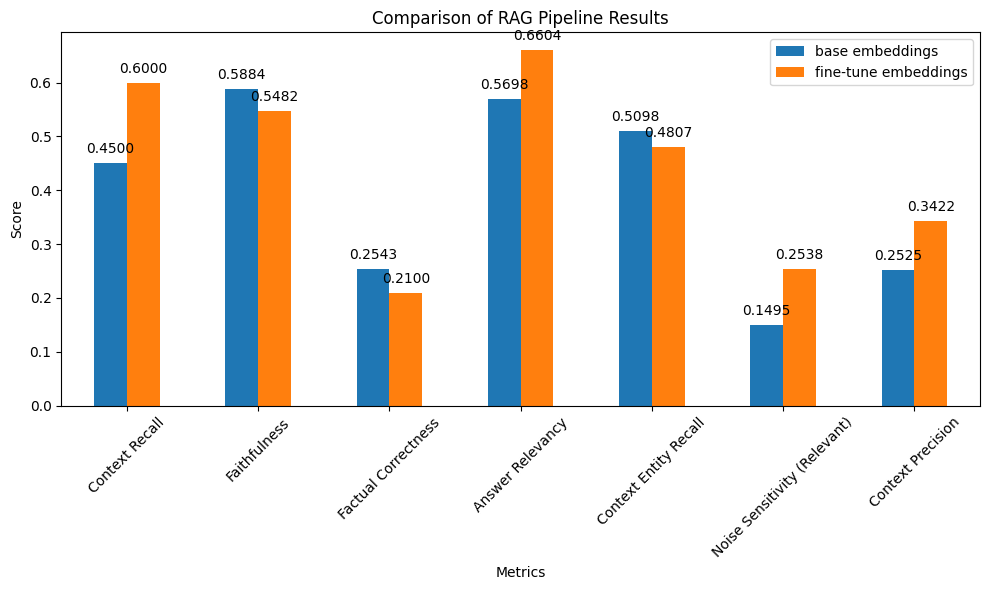

In [136]:
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Metric': ['Context Recall', 'Faithfulness', 'Factual Correctness', 'Answer Relevancy', 'Context Entity Recall', 'Noise Sensitivity (Relevant)', 'Context Precision'],
    'base embeddings': [0.4500, 0.5884, 0.2543, 0.5698, 0.5098, 0.1495, 0.2525],
    'fine-tune embeddings': [0.6000, 0.5482, 0.2100, 0.6604, 0.4807, 0.2538, 0.3422]
}

df = pd.DataFrame(data)
df = df.set_index('Metric')

# Plotting
ax = df.plot(kind='bar', figsize=(10, 6), rot=45)

# Add labels and title
plt.title('Comparison of RAG Pipeline Results')
plt.xlabel('Metrics')
plt.ylabel('Score')

# Add value labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()